Lets import all the pkgs needed

In [147]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import datetime

import matplotlib.pyplot as plt

We start by reading in the data

In [148]:
data = pd.read_csv("final_dataset_stocks.csv")
data.head()

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,...,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,...,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,...,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,...,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


We will drop the index column that came with the dataset 

In [149]:
data.drop(columns=['Unnamed: 0'], inplace=True)

we will drop the rows that includes na

In [150]:
#The rows with NaN are days when market was closed. I will be deleting those rows.
data.dropna(inplace=True)

In [151]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Even though we have removed null values, there still might be wrong non-numeric values here. Let's look at those dtypes.

In [152]:
data.select_dtypes(include=[object])

,date,SP_Volume,interest_rate,yield_rate
2,2012-01-03,--,2.01,1.97
3,2012-01-04,--,2.08,2.00
4,2012-01-05,--,2.12,2.02
5,2012-01-06,--,2.09,1.98
8,2012-01-09,--,2.11,1.98
...,...,...,...,...
3601,2021-11-10,--,2.7,1.56
3602,2021-11-11,--,.,.
3603,2021-11-12,--,2.73,1.58
3606,2021-11-15,--,2.76,1.63


In [153]:
data['SP_Volume'].value_counts()

--    2486
Name: SP_Volume, dtype: int64

Since all values are null, we will drop this column.

In [154]:
data.drop(columns=['SP_Volume'], inplace=True)

Next, we can notice some values in columns 'interest_rate' and 'yeild_rate' are "."

Let us replace it by the next numeric value in the series.

In [155]:
#Replacing values in yield_curves
for i in range(len(data)):
  if data.iloc[i,-1] == '.':
    data.iloc[i,-1] = data.iloc[i + 1,-1] 

In [156]:
data.columns.get_loc("interest_rate")

16

In [157]:
#Replacing values in interest rate
for i in range(len(data)):
  if data.iloc[i,16] == '.':
    data.iloc[i,16] = data.iloc[i + 1,16] 

In [158]:
#Converting the above columns into float
data['yield_rate'] = data['yield_rate'].astype('float')
data['interest_rate'] = data['interest_rate'].astype('float')
df=data

In [159]:
#Finally lets convert date string to datetime format
#for i in range(len(data)):
  #data.iloc[i,0] = datetime.datetime.strptime(data.iloc[i,0], '%Y-%m-%d')

data['date'] = pd.to_numeric(pd.to_datetime(data['date']))

In [160]:




data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,1325548800000000000,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,1325635200000000000,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,1325721600000000000,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,1325808000000000000,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,1326067200000000000,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Now, let us split the data into X and y. Since we are trying to predict the price of the Closing price of the IBM stock, we will make our split accordingly.

In [161]:
X = data.drop(columns =['IBM_close'])
y = data.IBM_close.values

Using sklearn, we will create a train_test_split.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

We will use the train data to build a linear regression


In [163]:
#LINEAR REGRESSION MODEL
model = LinearRegression().fit(X_train, y_train)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#predicted y values
y_pred = model.predict(X_test)
print(y_pred)

(6.073334662969904, 0.3751123220247885)
[131.11912817 130.70294259 127.9303857  101.76650987 129.28494318
 113.61755805 130.71130562 128.10993401 115.5853962  126.60447183
 114.05042325 115.91392938 116.03270315 116.22323807 112.10223195
 109.18709704 120.78255317 130.14912972 118.55529145 116.64642595
 126.54915119 118.77132421 116.27110032 115.29021828 127.28146873
 120.46173453 130.32649559 110.71831533 108.22215969 131.3322187
 129.08387345 127.69258647 117.07465838 117.18807415 118.46557244
 126.65464498 132.43433574 120.89437162 129.65156261 119.21875706
 112.37088009 116.9725316  120.84102891 127.69470407 108.72535127
 116.78401861 110.30810162 129.88010799 125.38469682 112.70572424
 129.53717117 117.38731331 113.78031318 115.619938   119.75679319
 130.51126013 117.57650453 118.15724774 116.38172074 127.82134146
 128.51886479 115.55918745 111.29597349 130.40963494 117.00573076
 112.79738769 128.75840812 125.18116434 127.45175092 127.20680918
 129.40819511 115.33972216 112.006543

In [164]:
#RIDGE REGRESSION
#can also test around with the alpha value, currently set to the default 1
ridgemodel = Ridge(alpha=1.0)

#k=5 or 10 is very common that generally result in a model skill estimate with low bias a modest variance
#can change this later
#repeat this process 3 times to get an average 
#evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(ridgemodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
ridgemodel.fit(X_train,y_train)
y_pred2 = ridgemodel.predict(X_test)
print(y_pred2)

(0.30623917582545557, 0.014967010553575967)
[134.46174842 129.65292985 143.44808063 119.6396405  131.60917476
 118.30754519 136.25432103 129.38935016 124.2550745  113.96816671
 134.4339474  110.75124655 118.08536942 124.73547972 115.24173406
 116.41272981 134.31382337 132.66312791 111.93953463 123.2851092
 129.59036612 139.31085304 120.59997912 121.20098229 122.96405275
 100.64397371 136.71800462 113.54086293 109.98523086 128.06959036
 120.63564997 110.76289309 110.17196088 107.90579142 119.90197048
 114.38912144 132.79314149 117.48126043 132.31093714 136.67222559
 108.91250117 130.85929456 131.77479698 135.50946696  99.72884249
 110.20346954 111.38318825 128.34118226 130.16985874 126.84368828
 135.6477405  119.30635331 106.21584355 127.17791266 127.15193989
 132.73117308  97.80644741 127.15707211 109.53309206 134.84937488
 141.59487046 119.01270377 102.06028304 131.11502713 127.98638514
 115.73954466 132.50439017 110.63961105 126.22721101 130.61944419
 122.67103609 125.8907445  123.18

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.86183e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.86068e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.86954e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.94891e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/andyc/opt/anaconda3/lib/pytho

In [165]:
#LASSO REGRESSION
#can also test around with the alpha value, currently set to the default 1
lassomodel = Lasso(alpha=1.0)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lassomodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
lassomodel.fit(X_train,y_train)
y_pred3 = lassomodel.predict(X_test)
print(y_pred3)

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+03, tolerance: 2.925e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+03, tolerance: 2.954e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

(0.44897213255576585, 0.026307284179481426)
[134.44911576 129.41989454 143.68565419 118.36632632 131.87932116
 119.34730197 135.93376711 129.65220783 124.00441929 114.38045044
 132.45756944 110.30912578 117.89367763 123.77828614 114.94701193
 115.61137696 134.31402965 132.50428991 112.03669073 123.20417941
 129.97593027 138.70196327 120.52150055 121.62619693 122.78324235
 101.21029862 136.21010231 113.62950953 110.07937005 128.27393772
 121.08874538 110.83468716 110.18627908 107.7330866  119.76108914
 114.30499169 132.34465909 117.66703554 132.32642592 136.18915197
 109.40498159 130.30838293 131.20337463 136.11287227 100.47927945
 110.35683762 112.05550899 128.51626998 130.64842409 126.4867764
 135.66344741 119.5733003  106.58108489 126.9586236  126.62091992
 132.95945006  98.50648554 126.86543827 109.53065254 134.58848572
 141.51442619 118.1547924  102.59313889 130.79352537 127.30325366
 115.66849757 132.64273962 111.60669189 126.42722513 131.00163068
 122.53216768 125.62233879 122.62

In [166]:
#ELASTIC NET REGRESSION
elasticmodel = ElasticNet(alpha=1.0, l1_ratio=0.5)

#evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(elasticmodel, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print((np.mean(scores), np.std(scores)))

#making predictions on test data
#first fit the data
elasticmodel.fit(X_train,y_train)
y_pred4 = elasticmodel.predict(X_test)
print(y_pred4)

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e+03, tolerance: 2.925e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+03, tolerance: 2.954e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

(0.44995733187229336, 0.027507364805636304)
[134.49454615 129.41834172 143.76883428 118.35190989 131.91490614
 119.33982701 135.94774029 129.63790132 124.06410479 114.35307289
 132.27517557 110.29949127 117.94508526 123.69866559 115.00692656
 115.63000991 134.41374537 132.5384031  112.02841308 123.26915468
 130.00252472 138.77615753 120.53521845 121.69693556 122.7733783
 101.15003479 136.19583031 113.65861779 110.08728758 128.26079198
 121.08575534 110.70732212 110.2122725  107.63712723 119.78675041
 114.28669053 132.31131769 117.69737567 132.33261324 136.2487189
 109.48014873 130.37790148 131.2260242  136.09752416 100.40034222
 110.37970219 111.98242474 128.52204817 130.65079377 126.53998673
 135.71484883 119.58606757 106.5635515  126.99940495 126.60445788
 132.98854407  98.45845996 126.89780982 109.49849304 134.62163603
 141.54783911 118.25208044 102.59808014 130.79474232 127.23616228
 115.69451243 132.68714178 111.50875394 126.43859392 131.04788521
 122.52547652 125.65682594 122.785

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e+03, tolerance: 2.912e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e+03, tolerance: 2.934e+01
  model = cd_fast.enet_coordinate_descent(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

In [167]:
#this converts the numeric date back to datetime (just to make the graph prettier)
#this is for actual date
for i in range(len(data)):
  your_timestamp = data.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  data.iloc[i,0] = date.date()
data.date = pd.to_datetime(data['date'])

#this is for the X_test
for i in range(len(X_test)):
  your_timestamp = X_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  X_test.iloc[i,0] = date.date()
X_test.date = pd.to_datetime(X_test['date'])
display(X_test)

,date,IBM_open,IBM_high,IBM_low,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
967,2014-08-24,134.5888,134.8842,134.1106,1723600.0,4563.720215,4571.140137,4547.779785,4557.350098,4557.350098,1.384620e+09,1997.92,1991.74,2001.95,1991.74,2.15,17743.227,2.39
886,2014-06-04,129.0926,130.0923,128.5753,2852200.0,4259.120117,4299.500000,4241.680176,4296.229980,4296.229980,1.926750e+09,1940.46,1928.52,1941.74,1922.93,2.18,17462.703,2.59
445,2013-03-20,145.0327,145.0599,143.0917,5830400.0,3228.169922,3237.570068,3215.689941,3222.600098,3222.600098,1.692260e+09,1545.80,1558.71,1558.71,1543.55,2.52,16629.050,1.95
3203,2020-10-07,117.2765,121.4349,116.2997,25269266.0,11443.349609,11448.230469,11384.330078,11420.980469,11420.980469,3.486530e+09,3446.83,3434.28,3447.28,3428.15,1.72,21477.597,0.78
856,2014-05-05,132.7047,132.7186,131.5370,3188700.0,4128.220215,4132.459961,4080.760010,4080.760010,4080.760010,1.850610e+09,1867.72,1883.69,1883.69,1867.72,2.16,17462.703,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,2019-09-02,115.1289,115.1727,113.8313,2827919.0,7906.439941,7940.370117,7847.319824,7874.160156,7874.160156,1.936210e+09,2906.27,2909.01,2914.39,2891.85,1.50,21505.012,1.47
1719,2016-09-14,116.0591,117.5860,115.2392,3662573.0,5178.100098,5254.779785,5176.250000,5249.689941,5249.689941,1.950940e+09,2147.26,2125.36,2151.31,2122.36,1.49,18775.459,1.71
2889,2019-11-28,115.4037,116.1984,114.9113,1825255.0,8682.009766,8697.320313,8664.040039,8665.469727,8665.469727,1.099090e+09,3140.98,3147.18,3150.30,3139.34,1.61,21694.458,1.78
2788,2019-08-19,115.4619,115.4960,113.3872,3018648.0,7989.359863,8010.580078,7948.089844,7948.560059,7948.560059,1.747580e+09,2900.51,2919.01,2923.63,2899.60,1.53,21505.012,1.55


/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


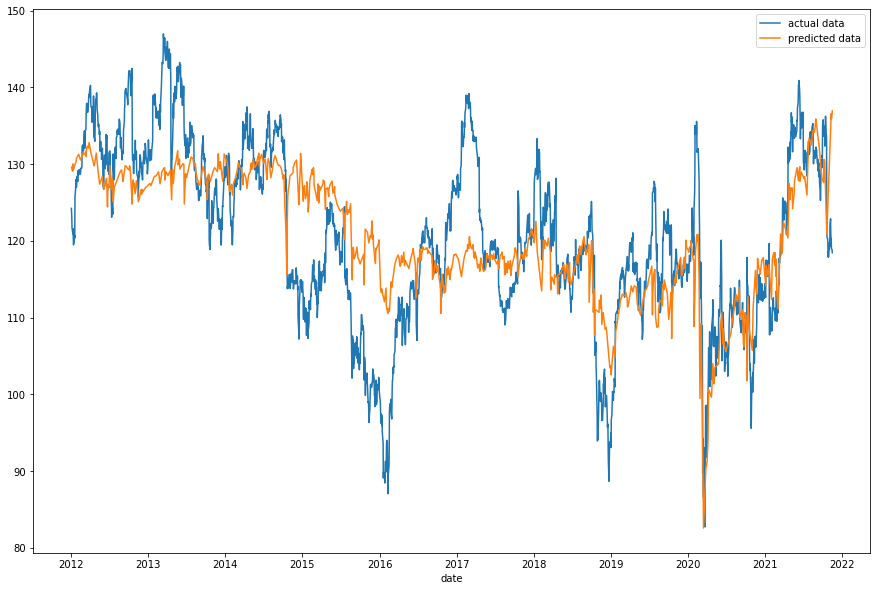

In [168]:
#PLOT THE LINEAR REGRESSION MODEL WITH PREDICTED VALUES
# this increases the figure size for added viewability
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

#plots the linear regression model
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test['date'],y_pred, label ="predicted data")
plt.show()

The Model above we trained multiple different linear regression models, we below we will train the random forest model below.

We start by splitting the data using Train_test_split

In [169]:
#construct X,y
# X = df.drop(columns =['IBM_close'])
# y = df.IBM_close.values


#split the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# #Feature scaling for random forest 
# from sklearn.preprocessing import StandardScaler
XX_test = X_test
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# display(X_train)
# X_test = sc.transform(X_test)

we will trian the Random Forrest here 

In [170]:
#import a few things here 
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [141]:
# Create RF
# Here we use the default MSE for our criterion
rf = RandomForestRegressor(n_estimators=10000, max_depth=3, n_jobs=-1, random_state=1,max_features=6,min_samples_leaf=2)

# Now we'll train/test
rf.fit(X_train,y_train)
ypr = rf.predict(X_test)


cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X, y,scoring='neg_mean_squared_error' ,cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Negative MSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))






KeyboardInterrupt: 

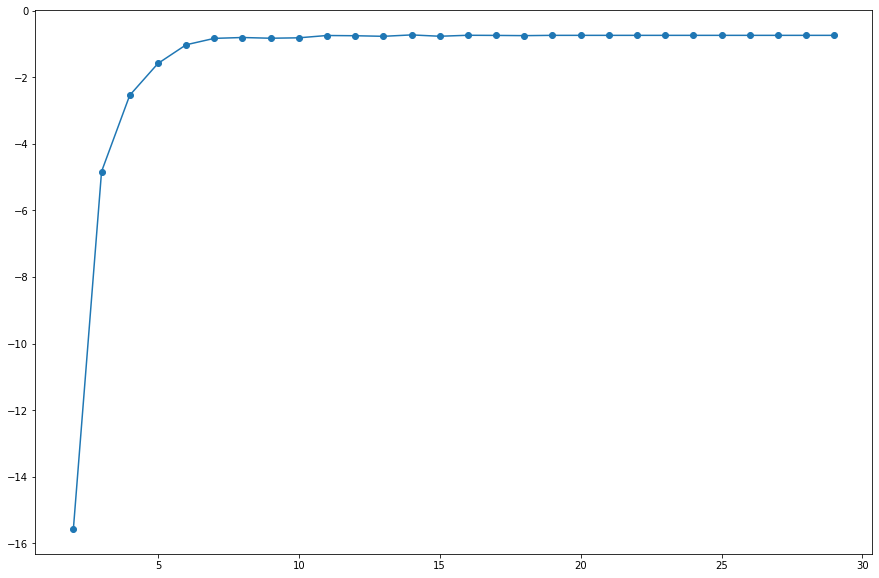

CV     -0.725725
XAX    14.000000
Name: 12, dtype: float64

In [ ]:
# Create and fit trees from max_depth 2 to max_depth 30. Use 5-fold CV for each.
CV_score = []
for i in range(2,30):
    tree = RandomForestRegressor(n_estimators=10, max_depth=i, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,30,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

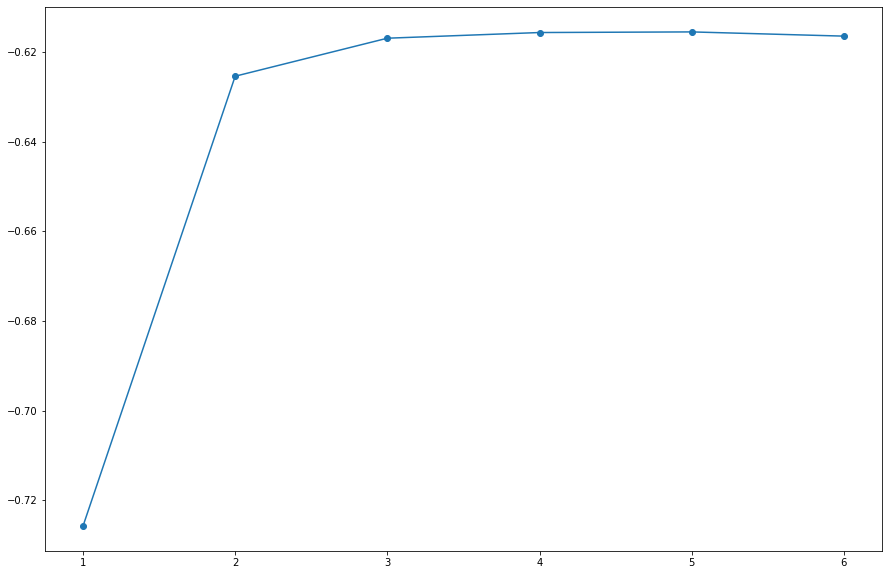

CV    -0.61547
XAX    5.00000
Name: 4, dtype: float64

In [ ]:
    
# Create and fit trees from n_est 10 to n_est 100000. Use 5-fold CV for each.
CV_score = []
n_est = [10,100,1000,5000,6000,10000]
for est in n_est:
    tree = RandomForestRegressor(n_estimators=est, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())
    
# Plot the mean CV score vs. n_est

x_axis = np.arange(1,7,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()


# Report the optimal estimator

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

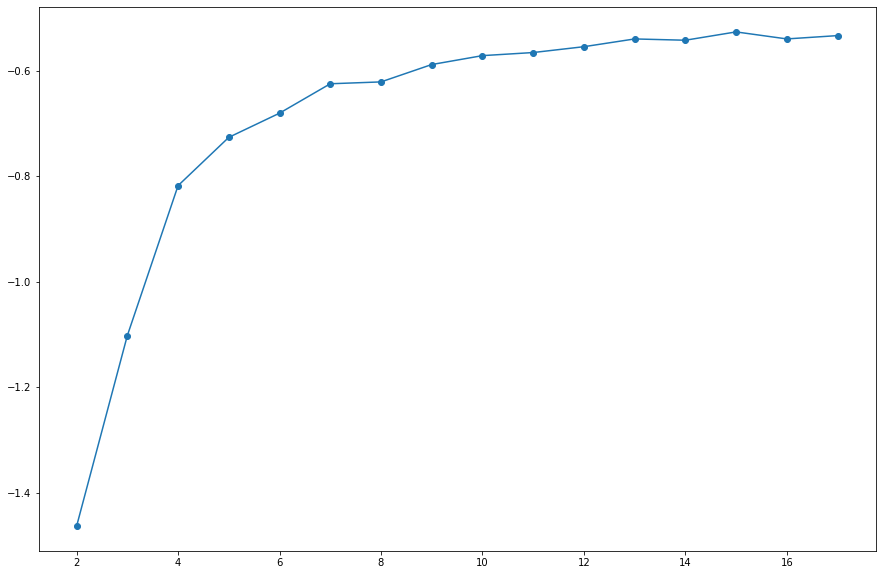

CV     -0.525691
XAX    15.000000
Name: 13, dtype: float64

In [ ]:
# Create and fit trees from max_features 2 to max_features 18. Use 5-fold CV for each.
CV_score = []
for i in range(2,18):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=i,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,18,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_feature

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

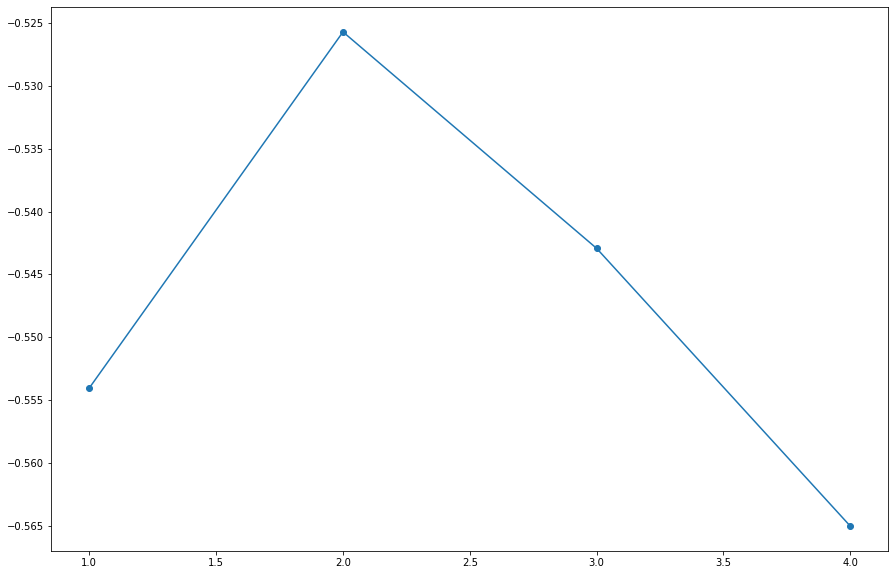

CV    -0.525691
XAX    2.000000
Name: 1, dtype: float64

In [ ]:
# Create and fit trees from min_samples_leaf 1 to 5. Use 5-fold CV for each.
CV_score = []
for i in range(1,4):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=15,min_samples_leaf=i)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(1,5,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

In [171]:
rf = RandomForestRegressor(n_estimators=6000, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
#drop_train = X_train.drop(columns=['IBM_open'],inplace=True)
# X_train = data[:int(len(data)*0.8)]
# y_train = data.IBM_close[:int(len(data)*0.8)]
# X_train.drop(columns=['IBM_close'],inplace=True)
# X_test = data[int(len(data)*0.8):]
# y_test = data.IBM_close[int(len(data)*0.8):]
# X_test.drop(columns=['IBM_close'],inplace=True)
# drop_train = X_train
# display(drop_train)
# drop_train.drop(columns=['IBM_high'],inplace=True)
# drop_train.drop(columns=['IBM_open'],inplace=True)
#display(drop_train.head())
rf.fit(X_train, y_train)
ypr_rf = rf.predict(X_test)

# sum((ypr_rf-y_test)**2)/len(ypr_rf)



print(ypr)

[117.42733733 113.42555917 129.91322076 132.98494714 127.99937043
 117.32224125 132.76986035 113.81084441 108.44098174 114.10607583
 114.31757872 104.08311282 117.76002264 117.25771466 135.99258916
 117.85597346 115.73142515 116.1194022  138.69393782 112.51006976
 113.8330242  117.94326055  95.92488789 113.58102371 133.85296099
 114.93407224 129.32379463 121.42407884 113.98737591 118.35518803
 117.00660683 103.07446881 132.71532616 112.78182458 100.52525686
 133.99806697 100.68206142 130.25512983 117.76524048 117.90044842
 127.7464334  129.69962493 114.49520542 114.39892249 103.48543909
 102.46239943 113.91096052  96.73519064 109.62242175 130.66200351
 130.40262425 130.61058093 130.69921786 122.49996182 117.80295985
 114.28401572 124.98123315 129.49552408 113.48271819 124.16586449
 127.74745452 105.0361779  131.65519783 124.14865714 133.12074036
 115.04316121 126.63019603 114.55240129 127.74487115 116.17775071
 112.43592381 112.34375027  99.65800466 123.67803114 115.25624738
 113.61073

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


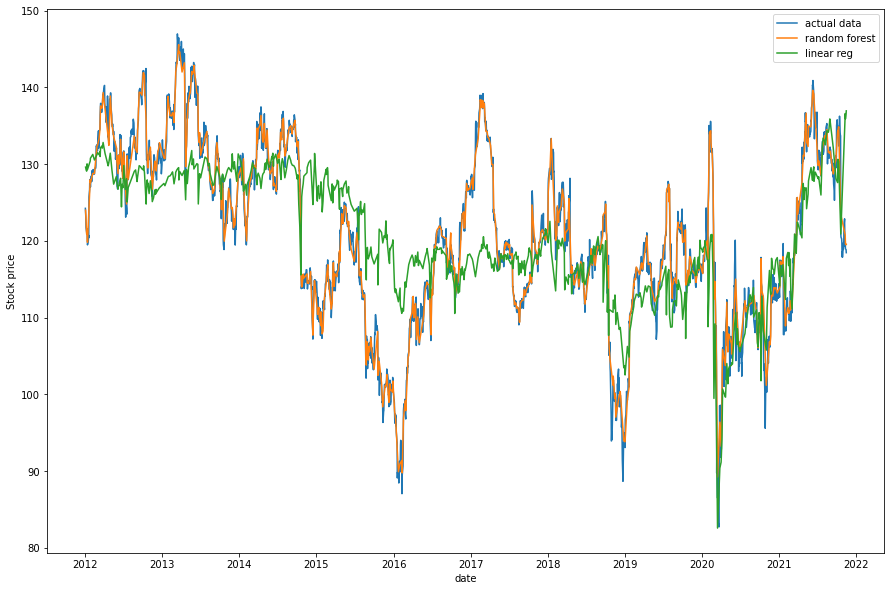

In [172]:
#Convert data column date back into date form
for i in range(len(XX_test)):
  your_timestamp = XX_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  XX_test.iloc[i,0] = date.date()
XX_test.date = pd.to_datetime(XX_test['date'])
#plots the Random Forrest model
#plot the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test.date,ypr_rf, label ="random forest")
ax = sns.lineplot(X_test['date'],y_pred, label ="linear reg")
plt.ylabel("Stock price")
plt.show()


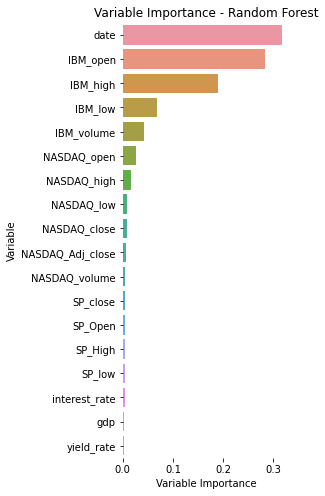

In [174]:
#Plot variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - Random Forest")
ax.set(ylabel="Variable",xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()

In [173]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,ypr_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test,ypr_rf))
print(mse)
print(rmse_rf)

mse_lin = mean_squared_error(y_test,y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test,y_pred))
print(mse_lin)
print(rmse_lin)

0.545209670598679
0.7383831462043801
66.23829590471408
8.13869128943432


Import XGboost pkg to fit a xgboost 

In [ ]:
from xgboost import XGBRegressor,XGBRFRegressor
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:

#split the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
XX_test = X_test

In [ ]:
# Here we want small trees (unlike with random forests)
# Boosting works better with less data as compared to RF
gb = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=1000, booster='gbtree', gamma=0.001, random_state=0)

In [ ]:
## Hyper Parameter Optimization
params={
    "n_estimators"     : range(1000,5000,1000),
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [ ]:
random_search=RandomizedSearchCV(
    gb,param_distributions=params,n_iter=5,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=3)

In [ ]:
#timer funciton 

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
#fit the training data into the search models 
from datetime import datetime

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time)


Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 2 minutes and 4.8 seconds.


In [ ]:
#show the best estimators
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
#show best parameters to use 
random_search.best_params_

{'n_estimators': 2000,
 'min_child_weight': 3,
 'max_depth': 10,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [ ]:
#fitting the fine tuned model
# gb = XGBRegressor(
#     base_score=0.5, 
#     booster='gbtree', 
#     colsample_bylevel=1,         
#     colsample_bynode=1, 
#     colsample_bytree=0.5, 
#     gamma=0.3, 
#     gpu_id=-1,
#     importance_type='gain', 
#     interaction_constraints='',
#     learning_rate=0.05, 
#     max_delta_step=0, 
#     max_depth=8,
#     min_child_weight=5, 
#     missing=None, 
#     monotone_constraints='()',
#     n_estimators=4000, 
#     n_jobs=8, 
#     num_parallel_tree=1, 
#     random_state=0,
#     reg_alpha=0, 
#     reg_lambda=1, 
#     scale_pos_weight=1, 
#     subsample=1,
#     tree_method='exact', 
#     validate_parameters=1, 
#     verbosity=None)

gb= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [ ]:
#cv score mean(neg mse)

score=cross_val_score(gb,X_train,y_train,cv=10,scoring='neg_mean_squared_error')
np.mean(score)

-0.5537011295741282

In [ ]:
# Train and test
gb.fit(X_train, y_train)
ypr_xg = gb.predict(X_test)



/Users/andyc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/andyc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/andyc/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid posit

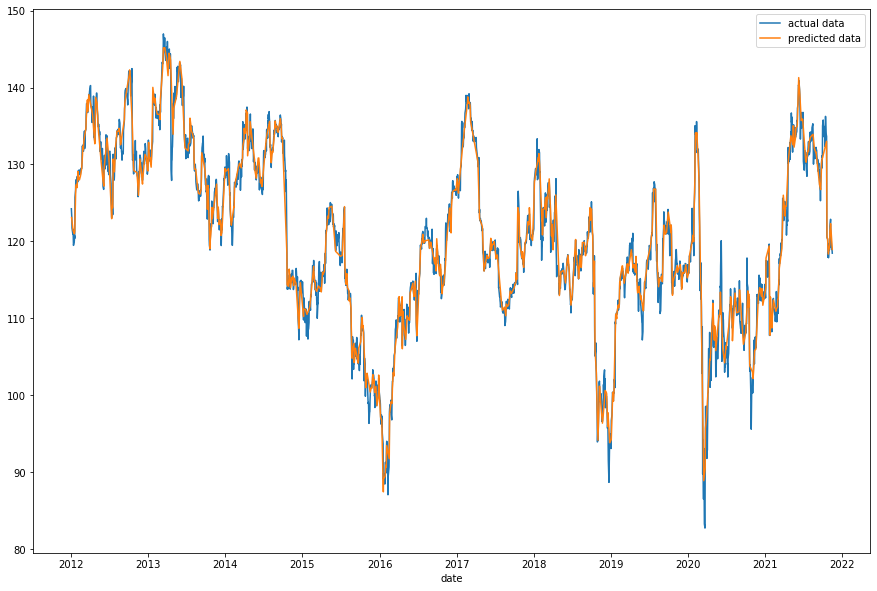

In [ ]:
#Convert data column date back into date form
import datetime

for i in range(len(XX_test)):
  your_timestamp = XX_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  XX_test.iloc[i,0] = date.date()
XX_test.date = pd.to_datetime(XX_test['date'])
#plots the Random Forrest model
#plot the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(XX_test.date,ypr_xg, label ="predicted data")
plt.show()

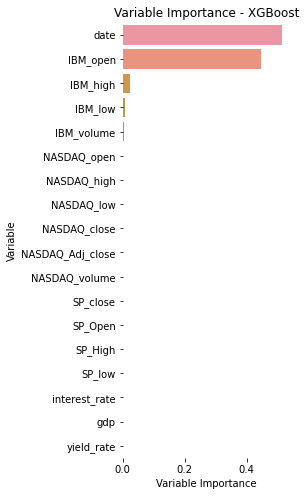

In [ ]:


# Plot variable importance
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - XGBoost")
ax.set(ylabel="Variable",xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()

/Users/andyc/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andyc/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


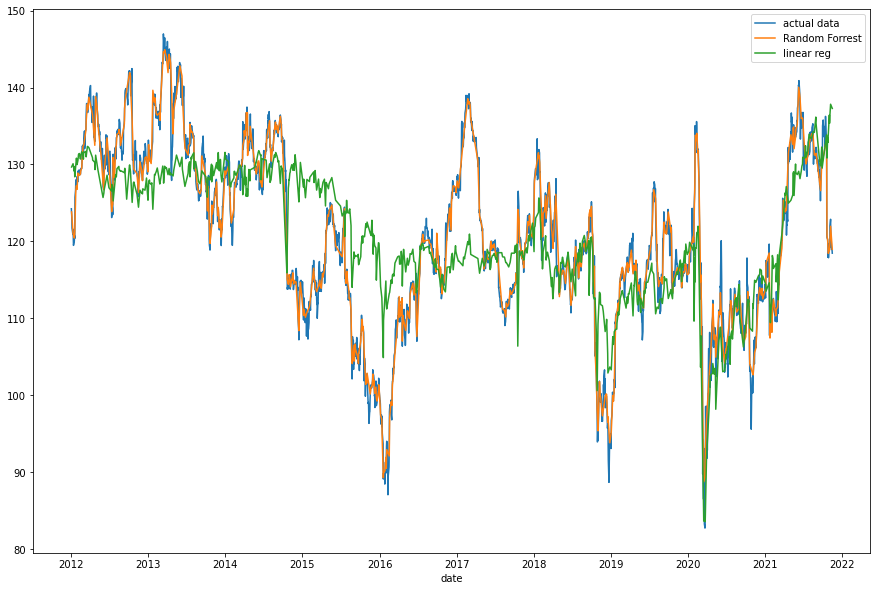

50289.92781245494
398.6551656364535


In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")

ax = sns.lineplot(XX_test.date,ypr_rf, label ="Random Forrest")
# ax = sns.lineplot(XX_test.date,ypr_xg, label ="XGBoost")
ax = sns.lineplot(X_test['date'],y_pred, label ="linear reg")
plt.show()

print(np.mean(sum((y_pred-y_test)**2)))
print(np.mean(sum((ypr_rf-y_test)**2)))
# print(np.mean(sum((ypr_xg-y_test)**2)))

In [ ]:
#let train an time series model using the traditional stock prediction methods 


In [ ]:
# # Let's do a grid search to tune the model hyperparameters
# # For XGBoost it's important to tune the number of trees (n_estimators) as it easily overfits
# param_grid = dict({'n_estimators': range(1,1000,100),'max_depth': range(3,10),'learning_rate' : np.linspace(0.01,0.1,10)})


# grid = GridSearchCV(gb, param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1, refit = True)
# grid.fit(X_train,y_train)

In [ ]:
# # Show the best params
# display(grid.cv_results_)
# display(grid.best_params_)